                                                                                            MSC 10/2022

# Resampling

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
    - [**Decimation and Expansion Defined**](#Decimation-and-Expansion-Defined)
    - [**Naive Downsampling**](#Naive-Downsampling) 
    - [**Aliasing**](#Aliasing)
    - [**Antialiasing Filters**](#Antialiasing-Filters)
- [**Mathematics of Downsampling**](#Mathematics-of-Downsampling)
    - [**Convolution with FIRs**](#Convolution-with-FIRs)
    - [**The Polyphase Decomposition**](#The-Polyphase-Decomposition)
- [**Downsampling in Openseize**](#Downsampling-in-Openseize) 
- [**Mathematics of Upsampling**](Mathematics-of-Upsampling)
- [**Upsampling in Openseize**](#Upsampling-in-Openseize)
- [**Resampling**](#Resampling)
- [**References**](#References)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from openseize import producer
from openseize.io.edf import Reader
from openseize.demos import paths
from openseize.filtering.fir import Kaiser

## Introduction

There are three possible operations that can be applied to a signal to change its sampling rate. The signal may be <b>downsampled</b> from a higher to a lower sampling rate, <b>upsampled</b> from a lower to higher sampling rate, or more generally <b>resampled</b> using a ratio of upsampling to downsampling to achieve non-integer conversion of the signal's sample rate. For example, resampling from 5 KHz to 1500 Hz requries upsampling by 3 then downsampling by a factor of 10. This tutorial covers the mathematics to downsampling and the design of resamplers in Openseize. As with filtering, this topic is deep and curious readers that want to go deeper are referred to the references at the end of this tutorial.

### Decimation and Expansion Defined

At the outset, it is important that a few terms are clarified. First are <b>Decimation</b> and <b>Expansion</b>. In this tutorial we refer to <b>M-fold decimation</b> as the process of picking every Mth sample from a sequence of samples $x[n]$. Mathematically, this is expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = x[nM] \quad (1)
    $ 
</p>
<br>
<br>
As we will see this is distinct from <b>Downsampling</b>. Second, we introduce <b>L-fold expansion</b> as the insertion of L zeros between each pair of samples in $x[n]$. Mathematically this is expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = x[\frac{n}{L}] = \begin{cases}
                               1 & \text{n is divisible by L} \\
                            0 & \text{otherwise}
                       \end{cases} \quad (2)
    $ 
</p>
<br>
<br>
Again this process is distinct from <b>Upsampling</b>.

### Naive Downsampling

With these definitions out of the way we will first examime how the frequency content of a signal changes when the signal is <b>decimated</b>. To do so we are going to fetch the first channel of data from our demo data. With this data we will then pick out every 25th element. Since the sample rate of the data is 5 KHz this should reduce the sampling rate to 200 Hz.

In [2]:
# lets read in the first 4 seconds of data from the demo file sampled at 5 KHz.
# if your not sure whats going on here please see the reading_files demo first
fp = paths.locate('recording_001.edf')
reader = Reader(fp)
reader.channels = [0]
fs = 5000
x = reader.read(0, 4*fs) #first 4 seconds of data

To examine the frequencies that are present in this signal, we will use the Fast Fourier Transform. 

In [3]:
# since the signal is real we use the real FFT and we build the frequencies
x_f = np.fft.rfft(x).reshape(-1,1)
x_freqs = np.fft.rfftfreq(x.shape[-1], d=1/fs)

So the plan here is to plot the frequency content of x, then decimate x by a factor of 25 and compare the frequency content with and without the decimation.

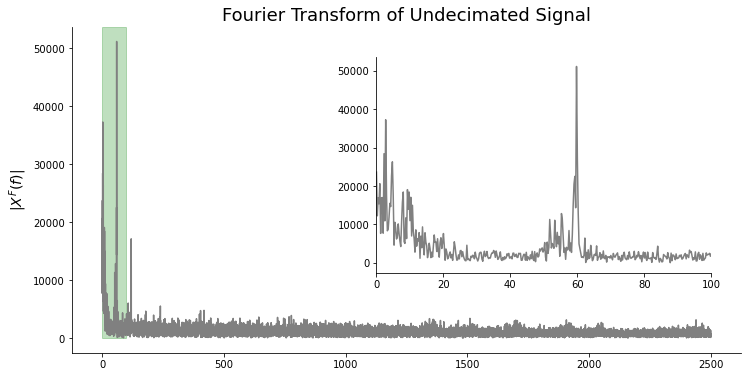

In [4]:
# plot the frequency content of the full signal and make a zoom to 100 Hz
fig, ax = plt.subplots(figsize=(12, 6))

#make axis with inset and then axarr
axinset = inset_axes(ax, width="50%", height=3, loc=1, borderpad=3)
axarr = [ax, axinset]

#plot and add rectangle for zoomed region
[ax.plot(x_freqs, np.abs(x_f), color='gray') for ax in axarr]
rect = Rectangle((0,0), 100, axarr[0].get_ylim()[-1], color='green', alpha=0.25)
axarr[0].add_patch(rect)

# set xlim of inset, labels, spines
axarr[1].set_xlim([0,100])
axarr[0].set_ylabel('$|X^F(f)|$', fontsize=14)
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]
ax.set_title('Fourier Transform of Undecimated Signal', fontsize=18)

plt.show()

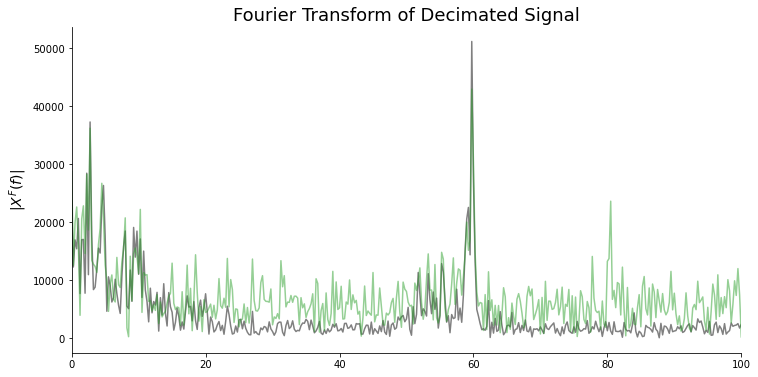

In [5]:
# Now decimate the signal by a factor of 25 reducing the sample rate from 5 KHz to 200 Hz
decimated = x[0, ::25]
decimated_f = np.fft.rfft(decimated)
decimated_freqs = np.fft.rfftfreq(decimated.shape[-1], d=1/fs * 25)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_freqs, np.abs(x_f), label='Undecimated', color='gray')
# note the factor of 25, we have 25x less signal so the amplitude drops by the decimation factor
ax.plot(decimated_freqs, 25*np.abs(decimated_f), label='25-fold Decimation', color='tab:green', alpha=0.5)

ax.set_ylabel('$|X^F(f)|$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlim([0,100])
ax.set_title('Fourier Transform of Decimated Signal', fontsize=18)
plt.show()


### Aliasing

What is going on here? Lets do a little thought experiment. Imagine a wheel with spokes that is spinning at a rate of 600 Hz and you have a strobe light that allows you to vary the freqeuncy of the light pulses. In an autoshop they call this a strobe gun. Next, you turn the lights out and start varying the frequency of the stobe gun. As you increase the frequency up towards 300 Hz (1/2 the wheels frequency) the wheel appears to slow down until you reach 300 Hz and then the wheel appears to stop! If you push the strobe gun a little above 300 Hz, the wheel then appears to rotate backwards. This phenomenon is called aliasing. The sampling done by the strobe gun has exceeded the nyquist rate (300 Hz) when this happens the frequencies in the range 300 - 600 Hz start to masqureade as lower frequencies. Hence the name aliasing.
<br>
<br>
<b>Mathematically, decimation causes the FFT to be replicated along the frequency axis.</b> If these replicates are too close (meaning the sampling exceeds the nyquist) they distort each other. This is what is occurring in our data. We have frequencies above our new nyquist of 100 Hz. All that signal from 100- 5kHz is masquerading as lower frequencies and distorting our signal. Thus, the frequency content in the range 0,100 Hz does not match the frequency content of the original signal in the same (0,100) Hz range.
<br>
<br>
Our discussion above hints at how to solve this problem. If we lowpass the data so that no signal is above 100 Hz <b>BEFORE</b> we decimate then there is no longer any high frequencies that can masquerade as low frequencies. Lets try this out. We will filter out the signal above 100 Hz then decimate and see if the frequency content of the result matches the frequency content of the original signal.

Next show that by first low-pass filtering the data we get the expected FFT after downsampling

### Antialiasing Filters

<b>The two step process of filtering then decimation is called <font color='firebrick'>Downsampling</font></b>. The filter that preceeds the M-fold decimation is called the antialias filter. It is typically designed so that the cutoff is at the new nyquist frequency. In this case that is 100 Hz. Also the width of the transition band is narrow ~ 10% of the cutoff frequency. Lets build a Kaiser filter to do just that and then decimate.

In [6]:
# Build a kaiser with the cutoff at the nyquist and set the transition width at 10% the nyquist.
kaiser = Kaiser(fpass=90, fstop=110, gpass=0.05, gstop=40, fs=5000)

#filter and decimate our signal by a factor of 25 from 5 kHz to 200 Hz
filtered = kaiser(x, chunksize=10e6, axis=-1)
antialiased = filtered[0, ::25]

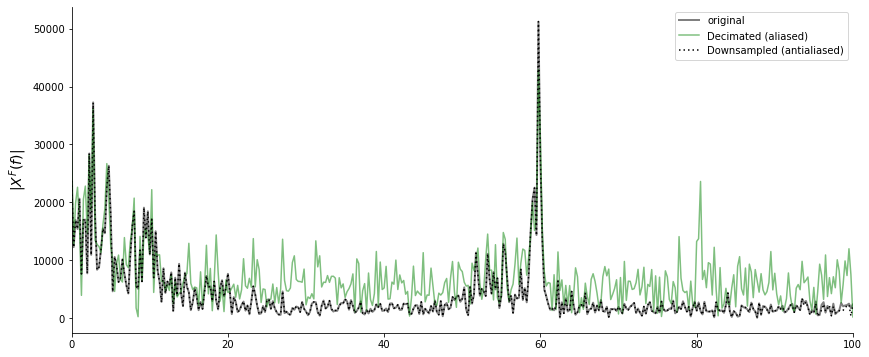

In [7]:
# Now lets again compare the frequency content of our signals
antialiased_f = np.fft.rfft(antialiased)
antialiased_freqs = np.fft.rfftfreq(antialiased.shape[-1], d=1/fs * 25)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x_freqs, np.abs(x_f), label='original', linewidth=2, color='gray')
ax.plot(decimated_freqs, 25*np.abs(decimated_f), label='Decimated (aliased)', color='green', alpha=0.5)
ax.plot(antialiased_freqs, 25*np.abs(antialiased_f), label='Downsampled (antialiased)', color='k', 
        linestyle=(0, [1,2]))

ax.set_xlim([0,100])
ax.set_ylabel('$|X^F(f)|$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend()
plt.show()

## Mathematics of Downsampling

In the preceeding section, we found that if we filter the original data from 5 KHz to 100 Hz before decimating, the resultant signal is no longer aliased. However, this is wasteful computationally because we are filtering all the data and then throwing out 24 out of every 25 samples during the decimation step. <i><b>Do we need to compute all the filtered values before decimating?</b></i>

### Convolution with FIRs

Applying a FIR filter $h[k]$ to a data sequence $x[n]$ is a convolution expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[i] x[n-i] \quad (3)
    $ 
</p>
<br>
<br>
For each sample n, we must perform K multiplications since the filter is K elements long. Similarly, M-fold downsampling can be expressed as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[i] x[nM-i] \quad (4)
    $ 
</p>
<br>
<br>
Which by the commutativity of convolution can be written as:
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=1}^{K} h[nM-i] x[i] \quad (5)
    $ 
</p>
<br>
<br>

### The Polyphase Decomposition

<b>So notice here that we need only every M filter values. So for FIR filters we can potentially reduce our computations to ~ K / M computations for each sample n. </b> To see how we can achieve this savings lets substitute into 4 (See B. Porat Ch 12):

<p style="text-align: center;">
    $
    i = i^{\prime} M + m \quad \text{where} \quad 0 \leq m \leq M-1
    $ 
</p>
giving:
<br>
<br>
<p style="text-align: center;">
    $
    \begin{align*}
    y[n] &= \sum \limits_{i=1}^{K} h[nM-i] x[i] = \sum \limits_{m=0}^{M-1} \sum \limits_{i^{\prime}} h[i^{\prime}M + m]x[nM-i^{\prime}M-m] \\
    &= \sum \limits_{m=0}^{M-1} \sum \limits_{i^{\prime}} h[i^{\prime}M + m]x[M(n-i^{\prime})-m] \quad (6)
    \end{align*}
    $ 
</p>
<br>
<br>

The effect of this substitution may not be obvious so lets work through a small example. Lets say we have a signal that we would like to down-sample by a factor of 3 and that the length of the filter h is 100 taps. 


for the m=0 terms the filter h is:
<br>
<br>
<p style="text-align: center;">
    $
    h[3i^{\prime}] = \{h[0],\ h[3],\ h[6], ... h[99]\}
    $ 
</p>
<br>
<br>
and the signal points are:
<br>
<br>
<p style="text-align: center;">
    $
    x[3(n-i^{\prime})] = \{x[3n],\ x[3n-3],\ x[3n-6], ... x[3n-99]\}
    $ 
</p>
<br>
<br>
So the convolutions for the m=0 subsequences are
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime}]x[3(n-i^{\prime})] \quad \text{for} \ m=0
    $ 
</p>
<br>
<br>

Similarly for m=1, the convolutions are:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime} + 1]x[3(n-i^{\prime})-1] \quad \text{for} \ m=1
    $ 
</p>
<br>
<br>
and for the m=2 subsequences, the convolutions are:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime} + 2]x[3(n-i^{\prime})-2] \quad \text{for} \ m=2
    $ 
</p>
<br>
<br>

<b>This substitution partitions the filter and subsequences into distinct subsequences</b> that are 1/3 the length of the original filter and data sequence x[n]. Thus each point in each data subsequence is only multiplied by 1/3 of the filters coeffs! These filter subsequences for each m are called the <b>polyphase components</b>.

Using our partitioning, the filtered values can be written as a sum over the convolutions of the subsequences:
<br>
<br>
<p style="text-align: center;">
    $
    \sum \limits_{i^{\prime}} h[3i^{\prime}]x[3(n-i^{\prime})] + \sum \limits_{i^{\prime}} h[3i^{\prime} + 1]x[3(n-i^{\prime})-1] + \sum \limits_{i^{\prime}} h[3i^{\prime} + 2]x[3(n-i^{\prime})-2]
    $ 
</p>
<br>
<br>

Just to reiterate, convolution requires K multiplications for each datapoint since the filter is K-elements long. This <b>polyphase</b> decomposition approach requires only K/M multiplications + M sums. <b>Polyphase decomposition picks out the correct filter and data samples to allow us to decimate BEFORE filtering.</b> This is an M-Fold computational savings!

Openseize implements polyphase decomposition for data sequences x[n] that are too large to fit into memory. We now turn to explore how to apply this functionality in the context of downsampling.

### Downsampling in Openseize